In [361]:
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm
from sklearn.datasets import make_blobs

if torch.cuda.is_available():
    print("GPU is available")
    import cupy as np
else:
    print("GPU is not available")
    import numpy as np

GPU is not available


In [380]:
import sys
np.set_printoptions(threshold=sys.maxsize)
class BBG:
	def __init__(self, alpha: float=2.0, epsilon: float=1.0):
		self.alpha = alpha
		self.epsilon = epsilon

	# algo 1: wavg is known
	def run_1(self, points: np.ndarray, k: int=-1, w_avg: float=1.0):
		distances = BBG.get_euclidean_distances(points)
		tau = 0.2 * (self.alpha * w_avg) / self.epsilon
		# print("tau: ", tau)
		tau_neighbors = np.where(distances <= tau, 1, 0) 
		b = (1 + 5/self.alpha)*self.epsilon*len(points)
		H = np.matmul(tau_neighbors, np.transpose(tau_neighbors))
		H = np.where(H >= b, 1, 0) # H contains the number of shared neighbors between each pair of points
		connected_components = BBG.find_components(H)
		top_k_component_indices = BBG.get_topk_components(connected_components, k)
		top_k_components = [connected_components[i] for i in top_k_component_indices]
		clusters = BBG.label_points(distances, top_k_components)
		return clusters

		
	
	#mxn matrix -> m points, each are in R^n. 
	def run_2(self, points: np.ndarray, k: int=-1):
		m = points.shape[0]
		n = points.shape[1]
		print("b condition: ", (1 + 5/self.alpha)*self.epsilon*m)
		print("total points condition: ", m*(1 - self.epsilon - 5*self.epsilon/self.alpha))
		distances = BBG.get_euclidean_distances(points)
		sorted_distances = np.sort(np.unique(np.ravel(distances)))
		prev_min_num_points_in_component = 0
		prev_top_k_components = []
		prev_num_components = 0
	
		for idx in tqdm(range(0, len(sorted_distances), max(len(sorted_distances)//5000, 1))):
			tau = sorted_distances[idx]
			if(tau == 0):
				continue
			tau_neighbors = np.where(distances <= tau, 1, 0) 
			b = (1 + 5/self.alpha)*self.epsilon*m

			H = np.matmul(tau_neighbors, np.transpose(tau_neighbors))
			
			H = np.where(H >= b, 1, 0) # H contains the number of shared neighbors between each pair of points

			
			connected_components = BBG.find_components(H)
			top_k_component_indices = BBG.get_topk_components(connected_components, k)
			top_k_components = [connected_components[i] for i in top_k_component_indices]
			# print("tau: ", tau, " num components: ", len(top_k_components), "components: ", top_k_components)
			total_points_in_all_components = sum(list(map(lambda x: len(x), top_k_components)))
			min_num_points_in_component = min(list(map(lambda x: len(x), top_k_components))
			)
			# if epoch % 100 == 0:
			# 	# print("epoch: ", epoch, "tau: ", tau,)
			# 	# print("num points in each component: ", list(map(lambda x: len(x), top_k_components)))
			# 	# print("total points in all components: ", total_points_in_all_components)
			# 	# print("min num points in component: ", min_num_points_in_component)
			# epoch += 1
			
			# can we run the last step?
			if min_num_points_in_component > b and total_points_in_all_components >= m*(1 - self.epsilon - 5*self.epsilon/self.alpha):
				print("stop early")
				print("best tau: ", tau)
				break
			# detect cluster merging
			if min_num_points_in_component > prev_min_num_points_in_component and len(top_k_components) < prev_num_components:
				print("cluster merging")
				print("best tau: ", tau)
				min_num_points_in_component = prev_min_num_points_in_component
				top_k_components = prev_top_k_components
				break
			prev_min_num_points_in_component = min_num_points_in_component
			prev_top_k_components = top_k_components
			prev_num_components = len(top_k_components)
		
		print("top_k_components final: ", top_k_components)
		clusters = BBG.label_points(distances, top_k_components)
		return clusters
		

	@staticmethod
	def label_points(distances, clusters):
		# distances is an mxm matrix where the (i,j) index contains the distance from point i to point j
		# clusters is a list of lists of indices where each list of indices represents a cluster
		# returns a list of labels of size m where the ith index contains the label of point i according to the 
		# minimum median distance from point i to all other points in each cluster
		labels = np.zeros(len(distances))
		for i in range(len(distances)):
			min_median = float('inf')
			for cluster_index, cluster in enumerate(clusters):
				median = np.median(distances[i][cluster])
				if median < min_median:
					min_median = median
					labels[i] = cluster_index
		return labels


		

	@staticmethod
	def find_components(H: np.ndarray): 
		visited = [False]*len(H)
		components = []
		for i in range(len(H)):
			if visited[i]:
				continue
			stack = [i]
			component = []
			while len(stack) != 0:
				curr = stack.pop()
				if visited[curr]:
					continue
				visited[curr] = True
				component.append(curr)
				stack.extend(list(np.ravel(np.argwhere(H[curr]))))
			components.append(component)
		return components

	@staticmethod
	def get_euclidean_distances(points: np.ndarray): 
		#points consists of m n-dim points in an mxn array. 
		#output is an mxm array where the (i,j) index contains
		#the distance from point i to point j in points. 
		return np.sqrt(np.sum((points[:, np.newaxis] - points)**2, axis=2))

	@staticmethod
	def get_topk_components(components, k):
		#components is a np list of lists of indices.
		#k is the number of components to return
		#returns the top k components by size
		# map the length of each component to its index
		sizes = np.array(list(map(lambda x: len(x), components)))
		k = min(k, len(components))
		return np.argpartition(sizes, -k)[-k:]

	@staticmethod
	def get_accuracy(labels, true_labels, points, k):
		# get median of each label
		medoids = []
		for label in range(k):
			medoid = np.median(points[np.where(labels == label)], axis=0)
			medoids.append(medoid)
		# get median of each true label
		true_medoids = []
		for label in range(k):
			medoid = np.median(points[np.where(true_labels == label)], axis=0)
			true_medoids.append(medoid)
		# relabel labels according to closest true median
		relabeled_labels = np.zeros(len(medoids))
		for i in range(len(medoids)):
			min_dist = float('inf')
			for j in range(len(true_medoids)):
				dist = np.linalg.norm(medoids[i] - true_medoids[j])
				if dist < min_dist:
					min_dist = dist
					relabeled_labels[i] = j
		# get accuracy of points according to relabeled labels
		accuracy = 0
		for i in range(len(points)):
			if relabeled_labels[int(labels[i])] == true_labels[i]:
				accuracy += 1
		return accuracy / len(points)

		

In [344]:
# # create data to test algorithm
# x, y = make_blobs(n_samples=500, centers=4, n_features=2, cluster_std=1)
# plt.scatter(x[:,0], x[:,1], c=y)
# plt.show()


cluster medians:  [array([0.59049386, 0.3889524 ], dtype=float32), array([0.58274186, 0.8140211 ], dtype=float32), array([0.72902083, 0.6882736 ], dtype=float32)]
w_avg:  0.08540871001314372


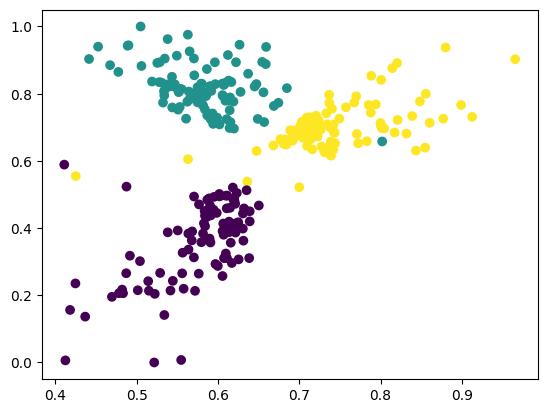

In [443]:
# load in mnist clusters
points = np.load('./mnist/out/bottleneck_features.npy')
true_labels = np.load('./mnist/out/labels.npy')
# map labels to 0-k labels
label_map = {}
for i, label in enumerate(np.unique(true_labels)):
    label_map[label] = i
for i in range(len(true_labels)):
    true_labels[i] = label_map[true_labels[i]]

# normalize points with 0-1 scaling
points = (points - np.min(points)) / (np.max(points) - np.min(points))
num_clusters = 3

# find median of each cluster
cluster_medians = []
for i in range(num_clusters):
    median = np.median(points[np.where(true_labels == i)], axis=0)
    cluster_medians.append(median)
print("cluster medians: ", cluster_medians)

# find average euclidean distance of each point to its respective cluster median
sum_weights = 0
for i in range(len(points)):
    sum_weights += np.linalg.norm(points[i] - cluster_medians[int(true_labels[i])])
w_avg = sum_weights / len(points)
print("w_avg: ", w_avg)
# plot points
plt.scatter(points[:,0], points[:,1], c=true_labels)
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]/Users/shikh/.pyenv/versions/3.9.1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shikh/.pyenv/versions/3.9.1/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|██████████| 16/16 [00:00<00:00, 16.03it/s]


best accuracy:  0.9566666666666667
k_medoids_accuracy:  0.9666666666666667


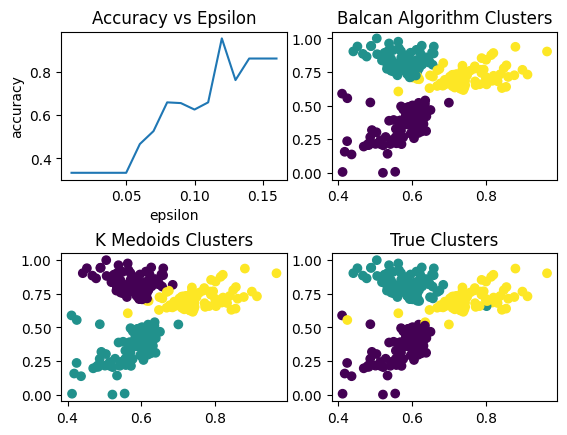

In [444]:
true_per_cluster_points = 100
# 2 * eps * n <= true_per_cluster_points
max_eps = true_per_cluster_points / (2 * len(points))
accuracies = []
max_accuracy = 0
best_clusters = []
best_eps = 0
for eps in tqdm(np.arange(0.01, max_eps, 0.01)):
    bbg = BBG(alpha=1.5, epsilon=eps)
    clusters = bbg.run_1(points, k=num_clusters, w_avg=w_avg)
    accuracy = BBG.get_accuracy(clusters, true_labels, points, num_clusters)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_clusters = clusters
        best_eps = eps
    accuracies.append(accuracy)
print("best accuracy: ", max_accuracy)

# cluster the points with k medioids from sklearn
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=num_clusters).fit(points)
sklearn_clusters = kmedoids.labels_
k_medoids_accuracy = BBG.get_accuracy(sklearn_clusters, true_labels, points, num_clusters)
print("k_medoids_accuracy: ", k_medoids_accuracy)
figure, ax = plt.subplots(2, 2)
# 2x2 grid of plots

# plot accuracies
ax[0, 0].plot(np.arange(0.01, max_eps, 0.01), accuracies)
ax[0, 0].set_xlabel("epsilon")
ax[0, 0].set_ylabel("accuracy")
ax[0, 0].set_title("Accuracy vs Epsilon")
# plot points in best cluster
ax[0, 1].set_title("Balcan Algorithm Clusters")
ax[0, 1].scatter(points[:, 0], points[:, 1], c=best_clusters)
# space between first and second row of plots
plt.subplots_adjust(hspace=0.5)
ax[1, 0].scatter(points[:, 0], points[:, 1], c=sklearn_clusters)
ax[1, 0].set_title("K Medoids Clusters")
# plot points with true labels
ax[1, 1].scatter(points[:, 0], points[:, 1], c=true_labels)
ax[1, 1].set_title("True Clusters")
plt.show()


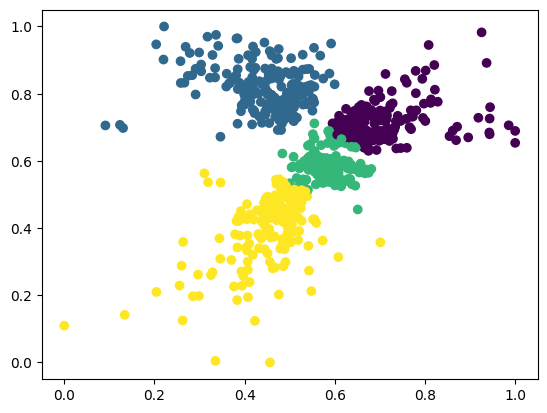

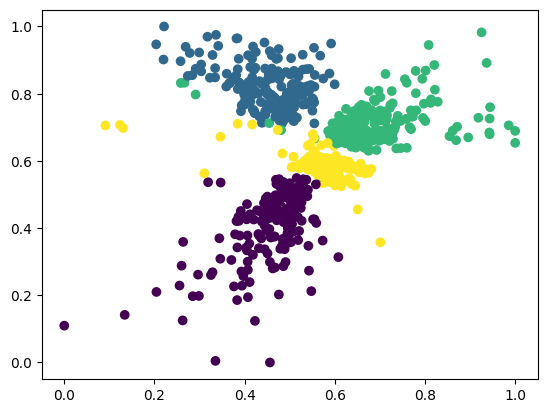

In [59]:
# from sklearn_extra.cluster import KMedoids

# kmedoids = KMedoids(n_clusters=4, random_state=0).fit(points)
# labels = kmedoids.labels_

# our_figure, our_axes = plt.subplots(1)
# our_axes.scatter(points[:, 0], points[:, 1], c=labels)

# true_figure, true_axes = plt.subplots(1)
# true_axes.scatter(points[:, 0], points[:, 1], c=true_labels)